# **Lab 5: Fully Connected Neural Networks**

---
NOTE: This is a lab project accompanying the following book [MLF] and it should be used together with the book.

[MLF] *H. Jiang*, "[Machine Learning Fundamentals: A Concise Introduction](http://wiki.eecs.yorku.ca/user/hj/research:mlfbook)", Cambridge University Press, 2021.  ([bibtex](http://www.cse.yorku.ca/~hj/mlf-jiang.bib))

---

The purpose of this lab is to study various methods to implement fully-connected neural networks (FCNNs) for pattern classification problems. First, we show how to use the MLP implementation from *scikit-learn* to build FCNN classifiers. Second, we will show how to use *numpy* to implement FCNNs from scratch based on the derived formula to compute both forward and backward passes. As training processes of large neural networks are typically very time-consuming on CPUs, furthermore, we will show how to use *JAX* to replace all *numpy* functions so as to run on GPUs. By doing so, we can see that the training speed of neural networks can be signicantly accelerated. Finally, we will show how to use the automatic differentiation (AD) functions available in *JAX* to re-implement FCNNs. In this case, we do not need to worry about how to compute gradients in our program because *jax.grad* will automatically derive gradients according to an objective function that is defined based on the model structure and learning criterion. As we can see, this can dramatically reduce our development efforts in implementing many machine learning models since we only need to define the forward pass of a model, and the model can be learned based on the automatically derived gradients from *jax.grad*.


Prerequisites: basic understanding on *JAX*, including *jax.numpy* and *jax.grad*.

## **I. Neural networks from scikit-learn**

### **Example 5.1:**

*Use the neural network implementation from scikit-learn, i.e. MLPClassifier, to build a classifier to recognize all ten digits in the MNIST data set. Investigate the best architecture for the fully connected neural networks (i.e., number of hidden layers and number of hidden nodes per layer) for this task, and fine-tune all hyper-parameters in the SGD optimizer towards the best possible performance.*


In [ ]:
#link my Google drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# install python_mnist

!pip install python_mnist

In [ ]:
#load MINST images

from mnist import MNIST
import numpy as np

mnist_loader = MNIST('/content/drive/My Drive/Colab Notebooks/datasets/MNIST')
train_data, train_label = mnist_loader.load_training()
test_data, test_label = mnist_loader.load_testing()
X_train = np.array(train_data, dtype='float')/255.0 # norm to [0,1]
y_train = np.array(train_label, dtype='short')
X_test = np.array(test_data, dtype='float')/255.0 # norm to [0,1]
y_test = np.array(test_label, dtype='short')

# convert MNIST training labels into 10-D one-hot vectors 
Y_train = np.zeros((y_train.size, y_train.max()+1))
Y_train[np.arange(y_train.size),y_train] = 1

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape, Y_train.shape)

(60000, 784) (60000,) (10000, 784) (10000,) (60000, 10)


In [ ]:
# build 10-digit classifer using MLPClassifier from scikit-learn

from sklearn.neural_network import MLPClassifier

# here are all hyper-parameters for MLPClassifier
#
mlp = MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(500,250), learning_rate='constant',
              learning_rate_init=0.1, max_fun=15000, max_iter=20, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=1, shuffle=True, solver='sgd', tol=0.0001,
              validation_fraction=0.1, verbose=10, warm_start=False)

mlp.fit(X_train, y_train)

print(f"Training set score: {mlp.score(X_train, y_train):.3f}")
print(f"Test set score: {mlp.score(X_test, y_test):.3f}")

Iteration 1, loss = 0.24301987
Iteration 2, loss = 0.08595058
Iteration 3, loss = 0.05706552
Iteration 4, loss = 0.03962371
Iteration 5, loss = 0.02908247
Iteration 6, loss = 0.01994459
Iteration 7, loss = 0.01544610
Iteration 8, loss = 0.01387832
Iteration 9, loss = 0.00784194
Iteration 10, loss = 0.00540533
Iteration 11, loss = 0.00432002
Iteration 12, loss = 0.00172743
Iteration 13, loss = 0.00105620
Iteration 14, loss = 0.00099268
Iteration 15, loss = 0.00071931
Iteration 16, loss = 0.00064104
Iteration 17, loss = 0.00060419
Iteration 18, loss = 0.00058721
Iteration 19, loss = 0.00057276
Iteration 20, loss = 0.00055686


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Training set score: 1.000
Test set score: 0.985


## **II. Fully Connected Neural Networks**

### **Example 5.2:**

*Implement your own fully connected neural networks from scratch. Use the stochastic gradient descent (SGD) to implement the error-backpropagation learning algorithm.  Use your implementation to build a classifier to recognize all ten digits in the MNIST data set. Compare your own implementation with that of scikit-learn in terms of accuracy and running speed.* 

In this implementation, we strictly follow the description and derived formula of FCNNs in [MLF]. In other words, we implement the mini-batch SGD in Algorithm 8.8 for model updating, and the forward pass on page 166 and backward pass on page 188 to compute gradients for model parameters. 

In our implementation, we support a flexible way that uses a python list to specify any model structure for FCNNs. For example, besides an input layer  and an output layer whose sizes are determined by input and output dimensions, if we specify *'struct = [100]'*, it means one more hidden layer of 100 nodes is added in between.  Similarly, *'struct = [500, 300, 100]'* is meant to add three more hidden layers of 500, 300, 100 nodes at each layer. 


In the backward pass for a mini-batch, we need to compute many outer products for all vectors in each mini-batch. For example, in any hidden layer, we have error signals $\{\mathbf{e}_1, \mathbf{e}_2, \cdots,  \mathbf{e}_{\tiny B}\}$ for all samples in the mini-batch, and their corresponding outputs from previous layer as  $\{\mathbf{z}_1, \mathbf{z}_2, \cdots,  \mathbf{z}_{\tiny B}\}$, as shown in the backward pass on page 188, we need to compute the following outer  products :
$$
\mathbf{e}_1 \mathbf{z}_1^\intercal, \mathbf{e}_2 \mathbf{z}_2^\intercal, \cdots, \mathbf{e}_{\tiny B} \mathbf{z}_{\tiny B}^\intercal
$$

In order to compute these outer products via vectorization, we use a handy method in *numpy*, i.e. [the Einstein summation](https://numpy.org/doc/stable/reference/generated/numpy.einsum.html). If we pack all error signals row by row as a $B \times O$ matrix $\mathbf{E}$, and outputs row by row as a $B \times I$ matrix $\mathbf{Z}$, the above outer products can be computed by one line of vectorized codes as follows:
```
numpy.einsum('bo,bi->bio', E, Z)
```


In [ ]:
# use numpy to implement fully-connected neural networks with mini-batch SGD 
import numpy as np

# ReLU activation function
def relu(x):
  return np.maximum(x, 0) 

# column-wise softmax
# X[N,d]: softmax over d
def softmax(X):
  m = X.max(axis=1)
  return np.transpose(np.exp(X.T-m)/np.sum(np.exp(X.T-m), axis=0))

class myMLP1():
  def __init__(self, optimizer='sgd', debug=0, struct=[], activation='relu',\
               loss='ce', lr=1.0, max_epochs=10, batch_size=10, random_state=1,\
               init_range=1.0, annealing=1.0):
    self.optimizer = optimizer     # which optimizer is used to learn
    self.lr = lr                   # initial learning rate in SGD
    self.annealing = annealing     # annealing rate in SGD
    self.max_epochs = max_epochs   # max epochs in optimization 
    self.batch_size = batch_size   # mini-batch size in SGD
    self.debug = debug             # whether print debugging info
    self.activation=activation     # activation function 
    self.loss = loss               # the loss used for training objective 
    self.random_state=random_state # random state
    self.init_range=init_range     # range for initializing weights 

    self.struct = struct           # network structure: e.g. [100], [500, 200], 
                                   #                         [100,100,100]
 
  # initialize internal struct/variables for input/output 
  # X[N,d]: input features; Y[N,K]: 1-of-K one-hot vectors for output targets 
  def initialization(self, X, Y):
    np.random.seed(self.random_state)

    input = X.shape[1]                # input dimension 
    self.layers = len(self.struct)    # number of hidden layers 
    self.W = [0]*(self.layers+1)      # list for all weight matrices
    self.b = [0]*(self.layers+1)      # list for all bias vectors 
    self.W_grad = [0]*(self.layers+1) # list for weight gradients
    self.b_grad = [0]*(self.layers+1) # list for bias gradients 

    # create weight matrices for all hidden layers 
    for l in range(self.layers):  
      output = self.struct[l]
      self.W[l] = 4.90*(np.random.rand(input, output)-0.5)*self.init_range/np.sqrt(output+input)
      self.b[l] = np.zeros(output)
      self.W_grad[l] = np.random.rand(input, output)
      self.b_grad[l] = np.zeros(output)
      input = output 

    # create weight matrix for output layer
    output = Y.shape[1]
    self.W[self.layers] = 4.90*(np.random.rand(input, output)-0.5)*self.init_range/np.sqrt(output+input)
    self.b[self.layers] = np.zeros(output)
    self.W_grad[self.layers] = np.random.rand(input, output)
    self.b_grad[self.layers] = np.zeros(output)


  # forward pass to compute outputs for a mini-batch X
  # if return_Z=True, also save all hidden activation 
  # (refer to the box on page 166)
  # input =>  X[B,d]: a batch of input vectors
  # if return_Z=False, return only y[B,K]
  # otherwise, return activations for all layers (including hidden layers) 
  def forward(self, X, return_Z=False):
    # list to save all hidden nodes' activation values 
    if (return_Z):
      Zs = [0] * (self.layers+2)
    else:
      Zs = [0]

    Z = X
    if(return_Z):
        Zs[0] = Z
    # forward pass from all hidden layers
    for l in range(self.layers): 
      Z = relu(Z @ self.W[l]  + self.b[l])
      if(return_Z):
        Zs[l+1] = Z

    #forward pass for output layer
    l = self.layers
    y = softmax(Z @ self.W[l] + self.b[l])
    if (return_Z):
      Zs[l+1] = y
    else:
      Zs[0] = y
    
    return Zs

  # backward pass to compute gradients for a mini-batch of inputs X and targets Y
  # Zs: list of all hidden activation values (pre-computed by a forward pass)
  # return gradients of all weight matrices and bias vectors 
  # (refer to the box on page 188)
  def backward(self, X, Y, Zs):
 
    # output layer
    l = len(Zs)-1
    e = Zs[l] - Y  # error signals for output layer 
    WG = np.einsum('bo,bi->bio', e, Zs[l-1])
    self.W_grad[l-1] = np.mean(WG,axis=0) 
    self.b_grad[l-1] = np.mean(e,axis=0)

    # backward for all hidden layers
    for l in range(self.layers,0,-1):
      e = ( e @ self.W[l].T ) * np.heaviside(Zs[l],0) 
      WG = np.einsum('bo,bi->bio', e, Zs[l-1])
      self.W_grad[l-1] = np.mean(WG,axis=0)
      self.b_grad[l-1] = np.mean(e,axis=0)

    return self.W_grad, self.b_grad

  # mini-batch SGD to update model parameters (Algorith 8.8 on page 189) 
  # X[N,d]: input feature vectors; Y[N,K]: one-hot output targets
  def sgd(self, X, Y):
    n = X.shape[0]            # number of samples

    lr = self.lr
    errorsA = np.zeros(self.max_epochs)
    errorsC = np.zeros(self.max_epochs)

    for epoch in range(self.max_epochs):
      indices = np.random.permutation(n)  #randomly shuffle data indices
      for batch_start in range(0, n, self.batch_size):
        X_batch = X[indices[batch_start:batch_start + self.batch_size]]
        Y_batch = Y[indices[batch_start:batch_start + self.batch_size]]

        Zs = self.forward(X_batch, return_Z=True)

        W_grad, b_grad = self.backward(X_batch, Y_batch, Zs)

        for l in range(self.layers+1):
          self.W[l] -= lr * W_grad[l]
          self.b[l] -= lr * b_grad[l]

      # plot all learning curves (A, B, C)
      Z = self.forward(X, return_Z=False)
      errorsC[epoch] = -np.mean (np.log(Z[0][Y==1]))

      train_label = np.argmax(Y, axis=1)
      train_res = np.argmax(Z[0], axis=1)
      errorsA[epoch] = np.count_nonzero(np.equal(train_res,train_label))/train_label.size

      if(self.debug):
        print(f'epoch = {epoch} (lr={lr:.2}): C = {errorsC[epoch]:.5f}  A = {100*errorsA[epoch]:.2f}%')

      lr *= self.annealing

    return errorsA, errorsC

  # X[N,d]: input feature vectors; Y[N,K]: one-hot output targets          
  def fit(self, X, Y):

    self.initialization(X, Y)

    errorsA, errorsC = self.sgd(X, Y)

    return errorsA, errorsC

  # X[N,d]: input features;
  # return: labels (NOT one-hot)
  def predict(self, X):
    Y = self.forward(X,return_Z=False)
    return np.argmax(Y[0], axis=1)
    

epoch = 0 (lr=0.1): C = 0.10536  A = 96.55%
epoch = 1 (lr=0.09): C = 0.04953  A = 98.42%
epoch = 2 (lr=0.081): C = 0.04733  A = 98.45%
epoch = 3 (lr=0.073): C = 0.01478  A = 99.59%
epoch = 4 (lr=0.066): C = 0.01039  A = 99.71%
epoch = 5 (lr=0.059): C = 0.00591  A = 99.86%
epoch = 6 (lr=0.053): C = 0.00259  A = 99.97%
epoch = 7 (lr=0.048): C = 0.00130  A = 99.99%
epoch = 8 (lr=0.043): C = 0.00081  A = 100.00%
epoch = 9 (lr=0.039): C = 0.00059  A = 100.00%
epoch = 10 (lr=0.035): C = 0.00052  A = 100.00%
epoch = 11 (lr=0.031): C = 0.00045  A = 100.00%
test accuracy = 98.50%


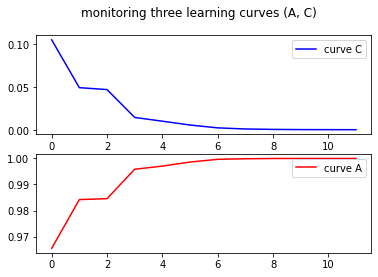

In [ ]:
import matplotlib.pyplot as plt

mlp = myMLP1(struct=[500,250], debug=1, max_epochs=12, annealing=0.9, batch_size=10,lr=0.1)

A, C = mlp.fit(X_train, Y_train)

result = mlp.predict(X_test)
test_acc =  100.0*jnp.count_nonzero(jnp.equal(result, y_test))/y_test.size
print(f'test accuracy = {test_acc:.2f}%')

fig, ax = plt.subplots(2)
fig.suptitle('monitoring three learning curves (A, C)')
ax[0].plot(C, 'b')
_=ax[0].legend(['curve C'])

ax[1].plot(A, 'r')
_=ax[1].legend(['curve A'])

## **III. Running Neural Networks on GPUs**

### **Example 5.3:**

*Re-implement the above fully connected neural networks using JAX so that we can run on GPUs for much faster training and testing speeds. Compare your JAX implementation with the above numpy codes in terms of classification accuracy and running speed.* 

*JAX* re-implements pretty much all *numpy* functions in its module *jax.numpy* and almost all *jax.numpy* functions adopt the same names and syntax as their *numpy* counterparts (with only a small number of exceptions).  Thus, it is straightforward to modify the above *numpy* codes into a JAX version by replacing all *numpy* functions with their *jax.numpy* counterparts. 

In this implementation, we have merged each weight matrix and its bias vector into a single matrix by expanding one more dimension of a constant '1' in its input vectors (as explained in the margin note on page 107). By doing so, we may be able to explore multiple GPU cores in a better way. 

In [ ]:
# implement fully-connected neural networks using JAX 
import numpy as np
import jax.numpy as jnp
import jax.nn as jnn
from jax import random, device_put

class myMLP2():
  def __init__(self, optimizer='sgd', debug=0, struct=[], activation='relu',\
               loss='ce', lr=1.0, max_epochs=10, batch_size=10, random_state=1,\
               init_range=1.0, annealing=1.0):
    self.optimizer = optimizer     # which optimizer is used to learn
    self.lr = lr                   # initial learning rate in SGD
    self.annealing = annealing     # annealing rate in SGD
    self.max_epochs = max_epochs   # max epochs in optimization 
    self.batch_size = batch_size   # mini-batch size in SGD
    self.debug = debug             # whether print debugging info
    self.activation=activation     # activation function 
    self.loss = loss               # the loss used for training objective 
    self.random_state=random_state # random state
    self.init_range=init_range     # range for initializing weights 

    self.struct = struct           # network structure: e.g. [100], [500, 200], 
                                   #                         [100,100,100]
 
  # initialize internal struct/variables for input/output 
  # X[N,d]: input features; Y[N,K]: 1-of-K one-hot vectors for output targets 
  def initialization(self, X, Y):
    key = random.PRNGKey(self.random_state)

    input = X.shape[1]                # input dimension 
    self.layers = len(self.struct)    # number of hidden layers 
    self.W_b = [0]*(self.layers+1)      # list for all weight matrices
    self.W_b_grad = [0]*(self.layers+1) # list for weight gradients

    # create weight matrices for all hidden layers 
    for l in range(self.layers):  
      output = self.struct[l]
      self.W_b[l] = device_put(4.90*(random.uniform(key,(input+1, output))-0.5)*self.init_range/jnp.sqrt(output+input))
      self.W_b_grad[l] = device_put(jnp.zeros((input+1, output)))
      input = output 

    # create weight matrix for output layer
    output = Y.shape[1]
    self.W_b[self.layers] = device_put(4.90*(random.uniform(key,(input+1, output))-0.5)*self.init_range/jnp.sqrt(output+input))
    self.W_b_grad[self.layers] = device_put(jnp.zeros((input+1, output)))

    return

  # forward pass to compute outputs for a mini-batch X
  # if return_Z=True, also save all hidden activation 
  # (refer to the box on page 166)
  # input =>  X[B,d]: a batch of input vectors
  # if return_Z=False, return only y[B,K]
  # otherwise, return activations for all layers (including hidden layers) 
  def forward(self, W_b, X, return_Z=False):
    # list to save all hidden nodes' activation values 
    if (return_Z):
      Zs = [0] * (self.layers+2)
    else:
      Zs = [0]

    # appending 1's to accomodate bias (see page 107)
    Z = jnp.hstack((X,jnp.ones((X.shape[0],1),dtype=X.dtype)))
    if(return_Z):
        Zs[0] = Z
    # forward pass from all hidden layers
    for l in range(self.layers): 
      Z = jnn.relu(Z @ W_b[l])
      Z = jnp.hstack((Z,jnp.ones((Z.shape[0],1),dtype=Z.dtype)))
      if(return_Z):
        Zs[l+1] = Z

    #forward pass for output layer
    l = self.layers
    y = jnn.softmax(Z @ W_b[l], axis=1)
    if (return_Z):
      Zs[l+1] = y
    else:
      Zs[0] = y
    
    return Zs

  # backward pass to compute gradients for a mini-batch of inputs X and targets Y
  # Zs: list of all hidden activation values (pre-computed in a forward pass)
  # return gradients of all weight matrices and bias vectors 
  # (refer to the box on page 188)
  def backward(self, X, Y, Zs):
 
    # output layer
    l = len(Zs)-1
    e = Zs[l] - Y  # error signals for output layer 
    WG = jnp.einsum('bo,bi->bio', e, Zs[l-1])
    self.W_b_grad[l-1] = jnp.mean(WG,axis=0) 

    # backward for all hidden layers
    for l in range(self.layers,0,-1):
      e = ( e @ self.W_b[l].T ) * jnp.heaviside(Zs[l],0)
      e = jnp.delete(e, -1, axis=1) # remove the column related to contant '1'

      WG = jnp.einsum('bo,bi->bio', e, Zs[l-1])
      self.W_b_grad[l-1] = jnp.mean(WG,axis=0)
 
    return 

  # compute the CE loss for a mini-batch
  # W_b[ ]: list for all weight matrices
  # X[B,d]: input features; 
  # Y[B,K]: 1-of-K one-hot vectors for output targets
  def loss_ce_batch(self, W_b, X, Y):
    R = self.forward(W_b, X, return_Z=False)

    return -jnp.mean(jnp.log(R[0][Y==1]))

  # mini-batch SGD to update model parameters (Algorith 8.8 on page 189) 
  # X[N,d]: input feature vectors; Y[N,K]: one-hot output targets
  def sgd(self, X, Y):
    n = X.shape[0]            # number of samples

    lr = self.lr
    errorsA = np.zeros(self.max_epochs)
    errorsC = np.zeros(self.max_epochs)

    for epoch in range(self.max_epochs):
      indices = np.random.permutation(n)  #randomly shuffle data indices
      for batch_start in range(0, n, self.batch_size):
        X_batch = X[indices[batch_start:batch_start + self.batch_size]]
        Y_batch = Y[indices[batch_start:batch_start + self.batch_size]]

        Zs = self.forward(self.W_b, X_batch, return_Z=True)

        self.backward(X_batch, Y_batch, Zs)

        for l in range(self.layers+1):
          self.W_b[l] -= lr * self.W_b_grad[l]
          
      # plot all learning curves (A and C)
      errorsC[epoch] = self.loss_ce_batch(self.W_b, X, Y)

      result = self.predict(X)
      errorsA[epoch] =  jnp.count_nonzero(jnp.equal(result, y_train))/y_train.size
 
      if(self.debug):
        print(f'epoch = {epoch} (lr={lr:.2}): C = {errorsC[epoch]:.5f}  A = {100*errorsA[epoch]:.2f}%')

      lr *= self.annealing

    return errorsA, errorsC

 # X[N,d]: input feature vectors; Y[N,K]: one-hot output targets         
  def fit(self, X, Y):

    self.initialization(X, Y)

    X2 = device_put(X)
    Y2 = device_put(Y)

    errorsA, errorsC = self.sgd(X2, Y2)

    return errorsA, errorsC

  # X[N,d]: input features;
  # return: labels (NOT one-hot)
  def predict(self, X):
    X2 = device_put(X)
    Y = self.forward(self.W_b, X2)
    return jnp.argmax(Y[0], axis=1)
    

epoch = 0 (lr=0.1): C = 0.09220  A = 97.22%
epoch = 1 (lr=0.09): C = 0.04670  A = 98.52%
epoch = 2 (lr=0.081): C = 0.03381  A = 98.94%
epoch = 3 (lr=0.073): C = 0.01755  A = 99.48%
epoch = 4 (lr=0.066): C = 0.01634  A = 99.48%
epoch = 5 (lr=0.059): C = 0.00456  A = 99.90%
epoch = 6 (lr=0.053): C = 0.00245  A = 99.95%
epoch = 7 (lr=0.048): C = 0.00167  A = 99.98%
epoch = 8 (lr=0.043): C = 0.00086  A = 99.99%
epoch = 9 (lr=0.039): C = 0.00063  A = 100.00%
epoch = 10 (lr=0.035): C = 0.00054  A = 100.00%
epoch = 11 (lr=0.031): C = 0.00048  A = 100.00%
test accuracy = 98.63%


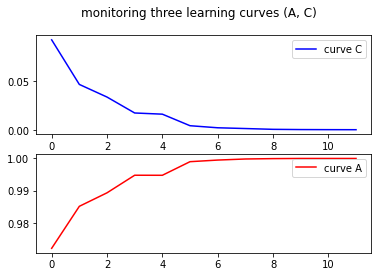

In [ ]:
import matplotlib.pyplot as plt

mlp = myMLP2(struct=[500,250], debug=1, max_epochs=12, annealing=0.9, batch_size=10,lr=0.1)

A, C = mlp.fit(X_train, Y_train)

result = mlp.predict(X_test)

test_acc =  100.0*jnp.count_nonzero(jnp.equal(result, y_test))/y_test.size
print(f'test accuracy = {test_acc:.2f}%')

fig, ax = plt.subplots(2)
fig.suptitle('monitoring three learning curves (A, C)')
ax[0].plot(C, 'b')
_=ax[0].legend(['curve C'])

ax[1].plot(A, 'r')
_=ax[1].legend(['curve A'])

In [ ]:
# show the GPU type used in the above computation

!nvidia-smi

Fri Jan 28 16:46:37 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### **Example 5.4:**

*Re-implement the above fully connected neural networks using JAX and its automatic differenttiation function jax.grad() so that you do not need to explicitly implement error back-propagation on your own. Compare this implementation with those in the previous examples and discuss the advantages to use automatic differentiation in implementing machine learning models.* 

Automatic differentiation is a convenient approach to implement many machine learning methods because it can ease us from lots of tedious derivations and implementations related to how to compute gradients for the models. In this case, we only need to specify the forward pass based on the model structure and then define an objective function according to the forward pass and a loss function. After that, we can use automatic differentiation, e.g. [*jax.grad()*](https://jax.readthedocs.io/en/latest/jax.html#jax.grad), to automatically compute the gradients w.r.t. model parameters, and directly run any gradient descent optimization method to update the model with the automatically derived gradients. 

In [ ]:
# implement fully-connected neural networks using JAX and jax.grad()
import numpy as np
import jax.numpy as jnp
import jax.nn as jnn
from jax import grad, random, device_put

class myMLP3():
  def __init__(self, optimizer='sgd', debug=0, struct=[], activation='relu',\
               loss='ce', lr=1.0, max_epochs=10, batch_size=10, random_state=1,\
               init_range=1.0, annealing=1.0):
    self.optimizer = optimizer     # which optimizer is used to learn
    self.lr = lr                   # initial learning rate in SGD
    self.annealing = annealing     # annealing rate in SGD
    self.max_epochs = max_epochs   # max epochs in optimization 
    self.batch_size = batch_size   # mini-batch size in SGD
    self.debug = debug             # whether print debugging info
    self.activation=activation     # activation function 
    self.loss = loss               # the loss used for training objective 
    self.random_state=random_state # random state
    self.init_range=init_range     # range for initializing weights 

    self.struct = struct           # network structure: e.g. [100], [500, 200], 
                                   #                         [100,100,100]
 
  # initialize internal struct/variables for input/output 
  # X[N,d]: input features; Y[N,K]: 1-of-K one-hot vectors for output targets 
  def initialization(self, X, Y):
    key = random.PRNGKey(self.random_state)

    input = X.shape[1]                # input dimension 
    self.layers = len(self.struct)    # number of hidden layers 
    self.W_b = [0]*(self.layers+1)    # list for all weight matrices

    # create weight matrices for all hidden layers 
    for l in range(self.layers):  
      output = self.struct[l]
      self.W_b[l] = device_put(4.90*(random.uniform(key,(input+1, output))-0.5)*self.init_range/jnp.sqrt(output+input))
      input = output 

    # create weight matrix for output layer
    output = Y.shape[1]
    self.W_b[self.layers] = device_put(4.90*(random.uniform(key,(input+1, output))-0.5)*self.init_range/jnp.sqrt(output+input))

    return

  # forward pass to compute outputs for a mini-batch X
  # (refer to the box on page 166)
  # input  =>  X[B,d]: a batch of input vectors
  # return =>  y[B,K]
  def forward(self, W_b, X):

    # appending 1's to accomodate bias (see page 107)
    Z = jnp.hstack((X,jnp.ones((X.shape[0],1),dtype=X.dtype)))

    # forward pass from all hidden layers
    for l in range(self.layers): 
      Z = jnn.relu(Z @ W_b[l])
      Z = jnp.hstack((Z,jnp.ones((Z.shape[0],1),dtype=Z.dtype)))

    # forward pass for output layer
    l = self.layers
    y = jnn.softmax(Z @ W_b[l], axis=1)
    
    return y

  # compute the CE loss for a mini-batch
  # W_b[ ]: list for all weight matrices
  # X[B,d]: input features; 
  # Y[B,K]: 1-of-K one-hot vectors for output targets
  def loss_ce_batch(self, W_b, X, Y):
    R = self.forward(W_b, X)

    return -jnp.mean(jnp.log(R[Y==1]))

  # use minibatch SGD to optimize (refer to Algorithm 8.8 on page 189)
  # X[N,d]: input features; Y[N,K]: 1-of-K one-hot vectors for output targets
  def sgd(self, X, Y):
    n = X.shape[0]      # number of samples

    lr = self.lr
    errorsA = np.zeros(self.max_epochs)
    #errorsB = np.zeros(self.max_epochs)
    errorsC = np.zeros(self.max_epochs)

    for epoch in range(self.max_epochs):
      indices = np.random.permutation(n)  #randomly shuffle data indices
      for batch_start in range(0, n, self.batch_size):
        X_batch = X[indices[batch_start:batch_start + self.batch_size]]
        Y_batch = Y[indices[batch_start:batch_start + self.batch_size]]

        W_b_grad = grad(self.loss_ce_batch)(self.W_b, X_batch, Y_batch)

        for l in range(self.layers+1):
          self.W_b[l] -= lr * W_b_grad[l]

      # plot all learning curves (A, B, C)
      errorsC[epoch] = self.loss_ce_batch(self.W_b, X, Y)

      Z = self.forward(self.W_b, X)
      train_label = np.argmax(Y, axis=1)
      train_res = np.argmax(Z, axis=1)
      errorsA[epoch] = np.count_nonzero(np.equal(train_res,train_label))/train_label.size

      if(self.debug):
        print(f'epoch = {epoch} (lr={lr:.2}): C = {errorsC[epoch]:.5f}  A = {100*errorsA[epoch]:.2f}%')

      lr *= self.annealing

    return errorsA, errorsC

   # X[N,d]: input features; Y[N,K]: 1-of-K one-hot vectors for output targets         
  def fit(self, X, Y):
    # initialize all weight matrices 
    self.initialization(X, Y)

    X2 = device_put(X)
    Y2 = device_put(Y)

    errorsA, errorsC = self.sgd(X2, Y2)

    return errorsA, errorsC

  # X[N,d]: input features;
  # return: labels 
  def predict(self, X):
    X2 = device_put(X)
    Y = self.forward(self.W_b, X2)
    return jnp.argmax(Y, axis=1)
    

epoch = 0 (lr=0.1): C = 0.13020  A = 96.16%
epoch = 1 (lr=0.098): C = 0.07862  A = 97.77%
epoch = 2 (lr=0.096): C = 0.06679  A = 98.03%
epoch = 3 (lr=0.094): C = 0.04262  A = 98.81%
epoch = 4 (lr=0.092): C = 0.02852  A = 99.28%
epoch = 5 (lr=0.09): C = 0.02375  A = 99.39%
epoch = 6 (lr=0.089): C = 0.02096  A = 99.48%
epoch = 7 (lr=0.087): C = 0.01511  A = 99.72%
epoch = 8 (lr=0.085): C = 0.01241  A = 99.73%
epoch = 9 (lr=0.083): C = 0.00811  A = 99.89%
epoch = 10 (lr=0.082): C = 0.00668  A = 99.92%
epoch = 11 (lr=0.08): C = 0.00487  A = 99.96%
epoch = 12 (lr=0.078): C = 0.00394  A = 99.98%
epoch = 13 (lr=0.077): C = 0.00305  A = 99.99%
epoch = 14 (lr=0.075): C = 0.00279  A = 99.99%
epoch = 15 (lr=0.074): C = 0.00234  A = 100.00%
epoch = 16 (lr=0.072): C = 0.00195  A = 100.00%
epoch = 17 (lr=0.071): C = 0.00177  A = 100.00%
epoch = 18 (lr=0.07): C = 0.00169  A = 100.00%
epoch = 19 (lr=0.068): C = 0.00148  A = 100.00%
test accuracy = 98.27%


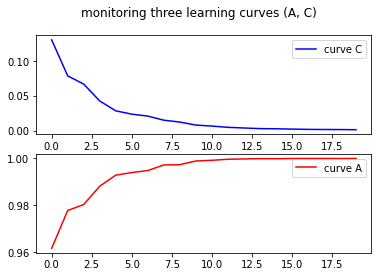

In [ ]:
import jax.numpy as jnp
import matplotlib.pyplot as plt

mlp = myMLP3(struct=[500,250], debug=1, max_epochs=20, annealing=0.98, batch_size=50,lr=0.1)

A, C = mlp.fit(X_train, Y_train)

result = mlp.predict(X_test)

test_acc =  100.0*jnp.count_nonzero(jnp.equal(result, y_test))/y_test.size
print(f'test accuracy = {test_acc:.2f}%')

fig, ax = plt.subplots(2)
fig.suptitle('monitoring three learning curves (A, C)')
ax[0].plot(C, 'b')
_=ax[0].legend(['curve C'])

ax[1].plot(A, 'r')
_=ax[1].legend(['curve A'])

In the following, we compare the total running times  (of 3 training epochs) among all three implementaions. As we can see, the JAX implemetation in Example 5.3 (running in GPUs) yields the fastest speed while the JAX autograd implementation in Example 5.4 (running in GPUs) is about twice slower (58.2 sec vs. 28.8 sec). On the other hand, the numpy implementation in Example 5.2 (running in CPUs) takes much longer time than those of JAX codes, about 10 times slower than the JAX implementation in Example 5.3 (running in GPUs), whose running times are measured as 293 sec vs. 28.8 sec. 

In [ ]:
# Measure and compare running times for all three different implementations 

print('numpy implementation running on CPUs') 

mlp = myMLP1(struct=[500,250], debug=0, max_epochs=3, annealing=0.99, batch_size=100,lr=0.1)

%timeit errorsA, errorsC = mlp.fit(X_train, Y_train)

%timeit result = mlp.predict(X_test)
result = mlp.predict(X_test)
test_acc =  100.0*jnp.count_nonzero(jnp.equal(result, y_test))/y_test.size
print(f'test accuracy = {test_acc:.2f}%')

print('JAX implementation running on GPUs') 

mlp = myMLP2(struct=[500,250], debug=0, max_epochs=3, annealing=0.99, batch_size=100,lr=0.1)

%timeit errorsA, errorsC = mlp.fit(X_train, Y_train)

%timeit result = mlp.predict(X_test)
result = mlp.predict(X_test)
test_acc =  100.0*jnp.count_nonzero(jnp.equal(result, y_test))/y_test.size
print(f'test accuracy = {test_acc:.2f}%')

print('JAX auto-grad implementation running on GPUs') 

mlp = myMLP3(struct=[500,250], debug=0, max_epochs=3, annealing=0.99, batch_size=100,lr=0.1)

%timeit errorsA, errorsC = mlp.fit(X_train, Y_train)

%timeit result = mlp.predict(X_test)
result = mlp.predict(X_test)
test_acc =  100.0*jnp.count_nonzero(jnp.equal(result, y_test))/y_test.size
print(f'test accuracy = {test_acc:.2f}%')


numpy implementation running on CPUs
1 loop, best of 5: 4min 53s per loop
1 loop, best of 5: 333 ms per loop
test accuracy = 96.46%
JAX implementation running on GPUs
1 loop, best of 5: 28.8 s per loop
100 loops, best of 5: 17.2 ms per loop
test accuracy = 96.82%
JAX auto-grad implementation running on GPUs
1 loop, best of 5: 58.2 s per loop
100 loops, best of 5: 17.5 ms per loop
test accuracy = 96.83%


## **Exercises**

### **Problem 5.1:**

Use automatic differentiation in *JAX*, i.e. *jax.grad()*, to re-implement logistic regression in Example 3.1, and then compare it with the *numpy* implementation in Example 3.1 in terms of classification accuracy and running speed. 

### **Problem 5.2:**

Use automatic differentiation in *JAX* to implement FCNNs for the *autoencoder* in Figure 4.15 on page 90. Use all training images in MNIST to train the autoencoder and then use its encoder part to extract features for two digits ('3' and '8') in MNIST. Use the extracted features in the training set to train a logistic regression model as in Problem 5.1 and evaluate classification accuracy using all digits '3' and '8' in the test set. Fine-tune the autoencoder structure towards the best possible classification accuracy between '3' and '8'. 

### **Problem 5.3:**

Use JAX automatic differentiation to implement FCNNs for the *bottleneck (BN) features* in Figure 4.16 on page 91. Use all training images in MNIST along with their labels to train the BN model and then use its encoder part to extract features for two digits ('3' and '8') in MNIST. Use the extracted features from the training set to train a logistic regression model as in Problem 5.1 and evaluate classification accuracy using digits '3' and '8' from the test set. Fine-tune the BN model structure towards the best possible classification accuracy between '3' and '8'. Compare the performance of *BN* features with that of autoencoder in Problem 5.2 and discuss the possible reason for the performance gap. 

### **Problem 5.4:**

Expand the FCNN implementation in Example 5.3 (or Example 5.4) by adding the *ADAM* optimzer in Algorithm 8.9 (on page 192) as another optimizer option for FCNNs. Compare ADAM with SGD in terms of the convergence behavior and classification accuracy.